Scrap Work

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from parallel_pandas import ParallelPandas

In [4]:
ParallelPandas.initialize(n_cpu=16, split_factor=4, disable_pr_bar=True)

Part 1: Building Preferences

In [11]:
def mdf_np(n, k = 3):
    x = pd.DataFrame(np.random.randint(0, n, (int(n*1.2),k)))
    x = x[~(x.apply(lambda row: len(row) != len(set(row)), axis=1))]
    if len(x)<n:
        return "Oops"
    else:
        x = x.iloc[:n].reset_index(drop=True)
        x['student_id'] = x.index
        x['applications'] = 0
    return x

In [12]:
def mdf_yp(n, k = 3):
    x = pd.DataFrame(np.random.randint(0, n, (int(n*1.2),k)))
    x = x[~(x.p_apply(lambda row: len(row) != len(set(row)), axis=1))]
    if len(x)<n:
        return "Oops"
    else:
        x = x.iloc[:n].reset_index(drop=True)
        x['student_id'] = x.index
        x['applications'] = 0
    return x

In [8]:
import time

In [20]:
def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        func(*args, **kwargs)
        end = time.time()
        return end-start
    return wrapper

In [21]:
@timeit
def test_np(n):
    mdf_np(n)

In [25]:
t_np = [test_np(n) for n in [1000, 10000, 100000, 1000000, 10000000]]

In [24]:
@timeit
def test_yp(n):
    mdf_yp(n)

In [26]:
t_yp = [test_yp(n) for n in [1000, 10000, 100000, 1000000, 10000000]]

In [31]:
np.array(t_yp)-np.array(t_np)

array([  3.39505887,   2.41605067,   1.82747173,  -3.01610374,
       -51.41541505])

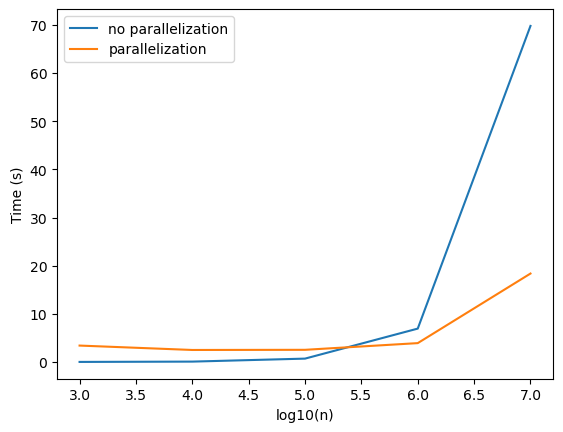

In [35]:
fig, ax = plt.subplots()
ax.plot(np.log10([1000, 10000, 100000, 1000000, 10000000]), t_np, label='np')
ax.plot(np.log10([1000, 10000, 100000, 1000000, 10000000]), t_yp, label='yp')
ax.yaxis.set_label_text('Time (s)')
ax.xaxis.set_label_text('log10(n)')
ax.legend(['no parallelization', 'parallelization'])

Gale Shapley Algorithm

In [68]:
def find_matches(sp):
    '''
    This function takes a dataframe of student preferences and returns a dataframe of matches.
    '''
    sp2 = sp[[0, 'student_id']] ## take the two relevant columns, chosen schools and student IDs
    matches = sp2.sample(frac=1).drop_duplicates(subset=0) ## Will have to reflect the Bayesian nature of this. 
    ## Save the number of applications for each school and then weigh students probabilities by the number of applications. 
    return matches ## Returns our first round of matches. 

In [69]:
def create_mask(sp3, sp):
    '''
    This function takes a dataframe of matches and a dataframe of student preferences and returns a mask of students who have not been assigned to a school.
    '''
    mask = ~(np.logical_or(sp['student_id'].isin(sp3['student_id']), sp['applications'] == 3)) ## creates a mask of all students who have not been assigned to a school. 
    return mask ## The mask gives all values that should be shifted over.

In [70]:
def shift(sp, mask, k = 3):
    '''
    This function takes a dataframe of student preferences, a mask of students who have not been assigned to a school, and the number of schools to apply to. 
    It returns an updated dataframe of student preferences. In this dataframe we have shifted over the values for students who have not been assigned to a school.
    We also update the number of failed applications each student has made.
    '''
    for i in np.arange(k-1):
        sp.loc[mask, i] = sp.loc[mask, i+1] # Shifts over all the values for relevant columns. 
    sp.loc[mask, 'applications'] += 1 ## Updates to new values.
    return sp ## Returns the updated dataframe.

In [88]:
def run_gale_shapley(sp):
    '''Runs the Gale-Shapley Algorithm for a particular dataframe'''
    r_apps = 0
    i=0
    mask = [1]
    while r_apps < 3 and sum(mask) > 0: ## note that there are two ways to end the cycle. 1 all unmatched students have applied to 3 schools. 2. There are no unmatched students.
        matches = find_matches(sp) ## Finds the first round of matches.
        mask = create_mask(matches, sp) ## Creates a mask of students who have not been assigned to a school.
        r_apps = sp.loc[mask, 'applications'].min() < 3 ## Check, if all rejects have already applied to three schools, we terminate. 
        sp = shift(sp, mask) ## Shifts over the values for students who have not been assigned to a school.
        i+=1
    return sp, i

In [94]:
sp = mdf_np(100000)

In [95]:
sp, i = run_gale_shapley(sp)

In [96]:
i

65

Finding ways to speed this up. The costliest part is the isin lookup. 

In [85]:
start = time.time()
matches = find_matches(sp)
end = time.time()
print(end-start)

0.22088241577148438


In [86]:
start = time.time()
create_mask(matches, sp)
end = time.time()
print(end-start)

0.07897782325744629


Possibly could do something with intersect 1D, which gives the index of schools that get a match? The part that actually takes time is the groupby. 

In [64]:
sp2 = sp[[0, 'student_id']]

In [67]:
sp2.sample(frac=1).drop_duplicates(subset=0)

,0,student_id
561714,39106,561714
341407,38414,341407
426288,916046,426288
459376,683316,459376
227136,670418,227136
...,...,...
484927,120238,484927
28667,874944,28667
336080,135015,336080
820448,491131,820448
